In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1.패키지 설치

In [ ]:
!pip install opencv-python opencv-contrib-python
!pip install numpy

2.라이브러리 import

In [2]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from io import BytesIO
from PIL import Image
import glob

3.카메라 캘리브레이션 함수

In [9]:
def calibrate_camera(image, pattern_size):
    objp = np.zeros((pattern_size[0] * pattern_size[1], 3), np.float32)
    objp[:, :2] = np.mgrid[0:pattern_size[0], 0:pattern_size[1]].T.reshape(-1, 2)

    objpoints = []  # 3D 포인트
    imgpoints = []  # 2D 포인트

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, pattern_size)

    if ret:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), 
                                    (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))
        imgpoints.append(corners2)

        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        return ret, mtx, dist, rvecs, tvecs
    else:
        return None, None, None, None, None


4.카메라 포즈 추정 함수 (오류?)

def estimate_camera_pose(image, camera_matrix, dist_coeffs):
    pattern_size = (6, 4)
    square_size = 0.04

    found, corners = cv.findChessboardCorners(image, pattern_size)
    print("Corners found:", found)

    if found:
        criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        corners2 = cv.cornerSubPix(cv.cvtColor(image, cv.COLOR_BGR2GRAY), corners, (11, 11), (-1, -1), criteria)

        objp = np.zeros((pattern_size[0] * pattern_size[1], 3), np.float32)
        objp[:, :2] = np.mgrid[0:pattern_size[0], 0:pattern_size[1]].T.reshape(-1, 2) * square_size

        success, rvecs, tvecs = cv.solvePnP(objp, corners2, camera_matrix, dist_coeffs)

        if success and rvecs.size == 3:
            rvecs = rvecs.reshape(3, 1)
            tvecs = tvecs.reshape(3, 1)
            return True, rvecs, tvecs
        else:
            print("solvePnP failed or returned unexpected results.")
            return False, None, None
    else:
        return False, None, None

In [2]:
def estimate_camera_pose(image, camera_matrix, dist_coeffs):
    pattern_size = (4, 4)

    found, corners = cv.findChessboardCorners(image, pattern_size)
    print("Corners found:", found)

    if found:
        criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        corners2 = cv.cornerSubPix(cv.cvtColor(image, cv.COLOR_BGR2GRAY), corners, (11, 11), (-1, -1), criteria)

        objp = np.zeros((pattern_size[0] * pattern_size[1], 3), np.float32)
        objp[:, :2] = np.mgrid[0:pattern_size[0], 0:pattern_size[1]].T.reshape(-1, 2) * square_size

        success, rvecs, tvecs = cv.solvePnP(objp, corners2, camera_matrix, dist_coeffs)

        if success:
            # rvecs 형태 변환
            rvecs = rvecs.flatten() if rvecs.size == 3 else rvecs
            rvecs = rvecs.reshape(3, 1)

            tvecs = tvecs.reshape(3, 1) if tvecs.size == 3 else tvecs
            return True, rvecs, tvecs
        else:
            print("solvePnP failed or returned unexpected results.")
            return False, None, None
    else:
        return False, None, None


5.특징점 감지 및 매칭 함수

In [3]:
def detect_and_match_features(img1, img2):
    AKAZE = cv2.AKAZE_create()

    kp1, des1 = AKAZE.detectAndCompute(img1, None)
    kp2, des2 = AKAZE.detectAndCompute(img2, None)

    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)

    flann = cv.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]

    img3 = cv.drawMatches(img1, kp1, img2, kp2, good_matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.imshow(img3),plt.show()

    return kp1, kp2, good_matches

6.트라이앵큘레이션 함수 (오류?)

def triangulate_points(kp1, kp2, good_matches, pose1, pose2, camera_matrix):
    success1, rvec1, tvec1 = pose1
    success2, rvec2, tvec2 = pose2

    if not (success1 and success2 and rvec1.size == 3 and rvec2.size == 3):
        print("Invalid input for triangulation.")
        return None

    R1, _ = cv.Rodrigues(rvec1)
    R2, _ = cv.Rodrigues(rvec2)
    P1 = np.hstack((R1, tvec1))
    P2 = np.hstack((R2, tvec2))

    P1 = camera_matrix.dot(P1)
    P2 = camera_matrix.dot(P2)

    pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 2)
    pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 2)

    points_4d_hom = cv.triangulatePoints(P1, P2, pts1.T, pts2.T)
    points_4d = points_4d_hom / points_4d_hom[3]
    points_3d = points_4d[:3, :].T

    return points_3d

In [4]:
def triangulate_points(kp1, kp2, good_matches, pose1, pose2, camera_matrix):
    success1, rvec1, tvec1 = pose1
    success2, rvec2, tvec2 = pose2

    if not (success1 and success2):
        print("Invalid input for triangulation: Pose estimation failed.")
        return None

    rvec1 = rvec1.reshape(3, 1) if rvec1.size == 3 else rvec1
    rvec2 = rvec2.reshape(3, 1) if rvec2.size == 3 else rvec2

    R1, _ = cv.Rodrigues(rvec1)
    R2, _ = cv.Rodrigues(rvec2)

    # tvec를 2차원 배열로 변경
    tvec1 = tvec1.reshape(-1, 1)
    tvec2 = tvec2.reshape(-1, 1)

    P1 = np.hstack((R1, tvec1))
    P2 = np.hstack((R2, tvec2))

    P1 = camera_matrix.dot(P1)
    P2 = camera_matrix.dot(P2)

    pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 2)
    pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 2)

    points_4d_hom = cv.triangulatePoints(P1, P2, pts1.T, pts2.T)
    points_4d = points_4d_hom / points_4d_hom[3]
    points_3d = points_4d[:3, :].T

    return points_3d


7.메인 워크플로우

In [5]:
# calibrate_camera, estimate_camera_pose, detect_and_match_features, triangulate_points 함수 활용

def main():
    # 카메라 캘리브레이션 이미지 로드
    calib_image_paths = glob.glob('/content/drive/MyDrive/231201_Calibration_Images/*.jpg')
    calib_images = []
    for image_path in calib_image_paths:
        image = cv.imread(image_path)
        if image is None:
            print(f"Failed to load image at path: {image_path}")
            continue
        calib_images.append(image)

    # 로드된 이미지가 없을 경우 함수 종료
    if not calib_images:
        print("No calibration images were loaded.")
        return

    # 카메라 캘리브레이션
    ret, mtx, dist, rvecs, tvecs = calibrate_camera(calib_images, pattern_size=(6, 4), square_size=0.04)
    if ret is None or not ret:
        print("Calibration was unsuccessful.")
        return

    # 레퍼런스 이미지 로드
    ref_image_path = '/content/drive/MyDrive/231130_Images/Reference.jpg'
    ref_image = cv.imread(ref_image_path)
    if ref_image is None:
        print(f"Failed to load reference image from path: {ref_image_path}")
        return

    # 레퍼런스 이미지에 대한 카메라 포즈 추정
    ref_pose_found, ref_rvecs, ref_tvecs = estimate_camera_pose(ref_image, mtx, dist)
    if not ref_pose_found:
        print("Reference image에서 포즈 추정 실패")
        return

    # 현재 이미지 로드
    current_image_path = '/content/drive/MyDrive/231130_Images/Present.jpg'
    current_image = cv.imread(current_image_path)
    if current_image is None:
        print(f"Failed to load current image from path: {current_image_path}")
        return

    # 현재 이미지에 대한 카메라 포즈 추정
    current_pose_found, current_rvecs, current_tvecs = estimate_camera_pose(current_image, mtx, dist)
    if not current_pose_found:
        print("Current image에서 포즈 추정 실패")
        return

    # 특징점 매칭
    kp1, kp2, good_matches = detect_and_match_features(ref_image, current_image)

    # 3D 포인트 트라이앵큘레이션
    points_3D = triangulate_points(kp1, kp2, good_matches, ref_rvecs, current_rvecs, mtx)

    # 결과 표시
    print("3D Points:", points_3D)

if __name__ == "__main__":
    main()


NameError: name 'glob' is not defined

Corners found: True
Image saved.
Corners found: True


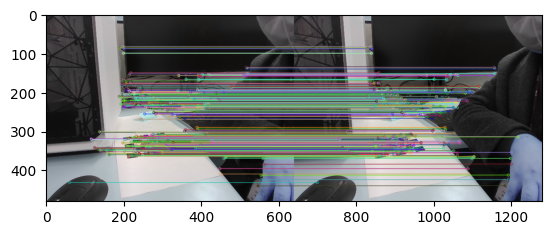

Corners found: True


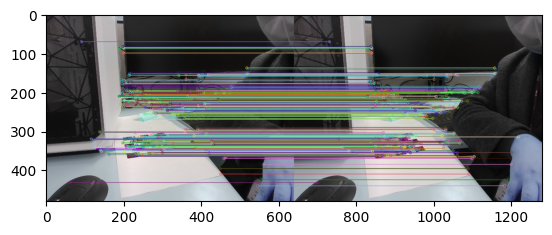

Corners found: True


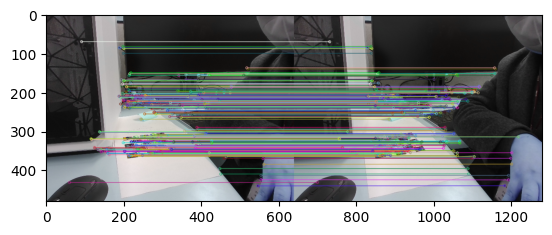

Corners found: True


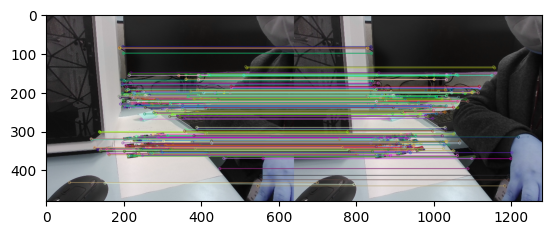

Corners found: True


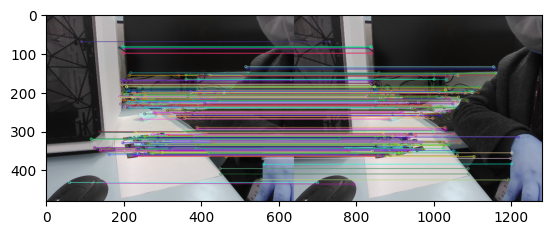

Corners found: True


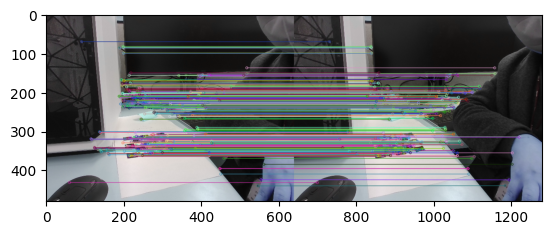

Corners found: True


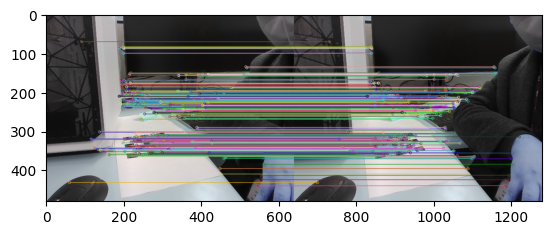

Corners found: True


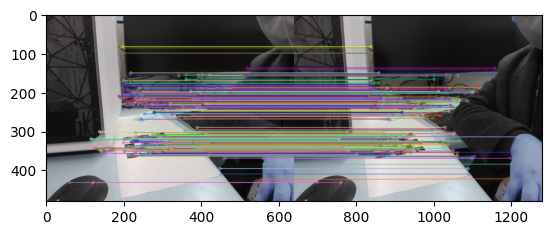

Corners found: True


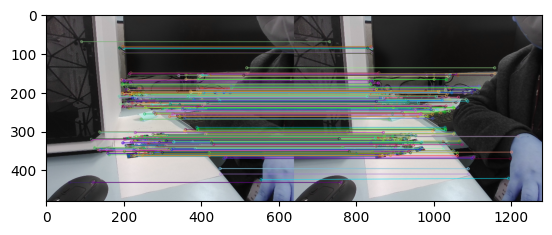

In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def estimate_camera_pose(image, camera_matrix, dist_coeffs):
    pattern_size = (4, 4)

    found, corners = cv.findChessboardCorners(image, pattern_size)
    print("Corners found:", found)

    if found:
        criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        corners2 = cv.cornerSubPix(cv.cvtColor(image, cv.COLOR_BGR2GRAY), corners, (11, 11), (-1, -1), criteria)

        objp = np.zeros((pattern_size[0] * pattern_size[1], 3), np.float32)
        objp[:, :2] = np.mgrid[0:pattern_size[0], 0:pattern_size[1]].T.reshape(-1, 2) * square_size

        success, rvecs, tvecs = cv.solvePnP(objp, corners2, camera_matrix, dist_coeffs)

        if success:

            return True, rvecs, tvecs
        else:
            print("solvePnP failed or returned unexpected results.")
            return False, None, None
    else:
        return False, None, None
    
def triangulate_points(kp1, kp2, good_matches, pose1, pose2, camera_matrix):
    P1 = pose1
    P2 = pose2

    P1 = camera_matrix @ P1
    P2 = camera_matrix @ P2

    pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches])

    points_4d_hom = cv.triangulatePoints(P1, P2, pts1.T, pts2.T)
    points_4d = points_4d_hom / points_4d_hom[3]
    points_3d = points_4d[:3, :].T

    return points_3d, P2

    
def detect_and_match_features(img1, img2):
    AKAZE = cv.AKAZE_create()

    kp1, des1 = AKAZE.detectAndCompute(img1, None)
    kp2, des2 = AKAZE.detectAndCompute(img2, None)

    bf = cv.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]

    img3 = cv.drawMatches(img1, kp1, img2, kp2, good_matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.imshow(img3),plt.show()

    return kp1, kp2, good_matches

# 카메라 매트릭스 및 왜곡 계수 불러오기
with np.load('camera_params.npz') as file:
    K = file['mtx']
    dist = file['dist']

# AKAZE 초기화
AKAZE = cv.AKAZE_create()

# 변수 초기화
saved_images = [] # 이미지 저장 여부

project_kp = False # 특징점 투영 여부

# 카메라 캘리브레이션을 위한 패턴 사이즈 및 체스보드 사각형 크기 설정
pattern_size = (4, 4)
square_size = 1.0 # 실제 체스보드의 사각형 크기

# 카메라 캡처 시작
cap = cv.VideoCapture(0)

while True:
    # 카메라 프레임 읽기
    ret, frame = cap.read()
    if not ret:
        break

    # 'c'를 눌러 현재 프레임 이미지 및 키포인트와 디스크립터 저장
    if cv.waitKey(1) & 0xFF == ord('c') and len(saved_images) == 0:
        saved_images = frame.copy()
        # 카메라 캘리브레이션을 위한 체스보드 코너 찾기
        saved_ret, saved_rvecs, saved_tvecs = estimate_camera_pose(saved_images, K, dist)
        if saved_ret:
            saved_R, _ = cv.Rodrigues(saved_rvecs)
            saved_RT = np.hstack((saved_R, saved_tvecs))
            print("Image saved.")
        else:
            print("Chessboard corners not found in saved image.")
            
    # 'm'을 눌러 현재 프레임과 저장된 이미지를 매칭하여 계속 표시
    if cv.waitKey(1) & 0xFF == ord('m') and len(saved_images) > 0:
        project_kp = True
        
    # 특징점 투영
    if project_kp:
        current_ret, current_rvecs, current_tvecs = estimate_camera_pose(frame, K, dist)
        
        if current_ret:
            kp1, kp2, good_matches = detect_and_match_features(saved_images, frame)
            
            current_R, _ = cv.Rodrigues(current_rvecs)
            current_RT = np.hstack((current_R, current_tvecs))
            
            points_3d, P2 = triangulate_points(kp1, kp2, good_matches, saved_RT, current_RT, K)
            
            for point in points_3d:
                point_3d_homogeneous = np.append(np.array(point), 1)
                # 2D 투영
                point_2d_homogeneous = np.dot(P2, point_3d_homogeneous)
                point_2d = point_2d_homogeneous[:2] / point_2d_homogeneous[2]
                x, y = point_2d  # 각 포인트의 x, y 좌표 추출

                # 업데이트된 좌표를 이미지에 그리기
                if 0 <= x < frame.shape[1] and 0 <= y < frame.shape[0]:
                    cv.circle(frame, (int(x), int(y)), 5, (0, 255, 0), -1)

    cv.imshow('Camera Feed', frame)

    # 'q'을 눌러 카메라 이미지 표시 종료
    if cv.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv.destroyAllWindows()